<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Hackathon - Good Fast Cheap
## Notebook 1
Group members:  Stephen Strawbridge, Michael Winder, Max Bossee, Aziz Maredia - Cohort #1019

---
# Section 1 - Introduction and Problem Statement

---

**Problem Statement**:  We hypothesize that given a limited number of features (under 20), classification prediction on if an individual's income is above a certain threshold can be highly reliable.

### Contents
* Notebook 1 (this notebook)
* Notebook 2  (best performing model)


----

# Section 2 
## Imports & Data Cleaning & Engineering


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
#Read in data
df = pd.read_csv('./data/large_train_sample.csv')

In [3]:
#check out data info (no nulls found)
df.info()

#Data integrity of datatypes is all good as well

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  wage            32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [4]:
#Dataframe is now clean and ready for feature engineering!

## Feature Engineering

In [5]:
#Feature engineer capital-gain-bool column to indicate if individual had a capital gain (1) or not (0)
df['capital-gain-bool'] = (df['capital-gain'] > 0).astype(int)

In [6]:
#Binarize sex into male and female
df['sex'] = df['sex'].map({' Male': 1, ' Female' : 0})

In [7]:
#Create target column
df['target'] = (df['wage']==' >50K').astype(int)

In [8]:
#Also drop relationship column, as this is redundant with marital-status
df = df.drop(columns='relationship')

#Also drop 'fnlwgt' column, as after doing EDA, we noted this feature had extremely minimal correlation
df = df.drop(columns='fnlwgt')

In [9]:
#For education, we are categorizing different levels into more generic categories using mapping function.  Total number of categories for education is now 6.
edu_map = {
    ' Preschool': 'below-hs',
    ' 1st-4th' : 'below-hs',
    ' 5th-6th' : 'below-hs',
    ' 7th-8th' : 'below-hs',
    ' 9th' : 'below-hs',
    ' 10th' : 'below-hs',
    ' 11th' : 'below-hs',
    ' 12th' : 'hs-grad',
    ' HS-grad' : 'hs-grad',
    ' Assoc-acdm': 'assoc_some_college',
    ' Assoc-voc': 'assoc_some_college',
    ' Some-college': 'assoc_some_college',
    ' Bachelors' : 'bachelors',
    ' Masters' : 'masters',
    ' Doctorate' : 'doc_prof',
    ' Prof-school' : 'doc_prof'
}

#Map variables
df['education'] = df['education'].map(edu_map)

#Now dummify education column
df = pd.get_dummies(data=df, columns=['education'], drop_first=True)

In [10]:
#Dataframe is now ready for train-test-split
df.to_csv('./data/cleaned_df.csv')

## Train-test-split

In [11]:
#Define X and y and do train-test-split
X = df.drop(columns=['wage'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [12]:
#Features to map
map_features = ['workclass', 'marital-status', 'occupation', 'native-country']

In [13]:
#Map the probability of reaching target for each feature into the feature columns (which are categorical columns)
map_dicts = {}
for feature in map_features:
    feat_num = list(X_train.groupby(by=feature)['target'].mean())
    feat_list = list(X_train[feature].sort_values().unique())
    feat_dict = dict(zip(feat_list, feat_num))
    
    #map_dicts.append(feat_dict)
    map_dicts[feature] = feat_dict
    X_train[feature]=  X_train[feature].map(feat_dict)
    

<ipython-input-13-48794dd8820d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[feature]=  X_train[feature].map(feat_dict)


In [14]:
#Map the same dictionary from X_train to the X_test dataset
for feature in map_features:  
    X_test[feature]=  X_test[feature].map(map_dicts[feature])

<ipython-input-14-8b47f5a111b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[feature]=  X_test[feature].map(map_dicts[feature])


In [15]:
#It was noted that X_test had one null value - drop this row
X_test = X_test.dropna()

#In order to drop same row in y_test, reset the y_test variable with updated X_test
y_test = X_test['target']

---
# Section 3

---
## EDA

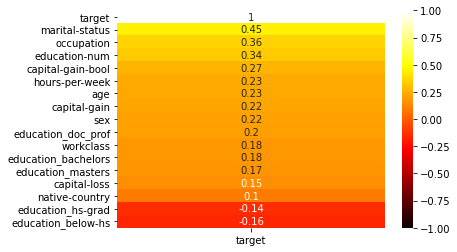

In [16]:
#Look at correlation between our dependent variable and other features
sns.heatmap(X_train.corr()[['target']].sort_values(by='target', ascending=False),
            vmin = -1, vmax = 1,
            cmap = 'hot',
            annot = True);

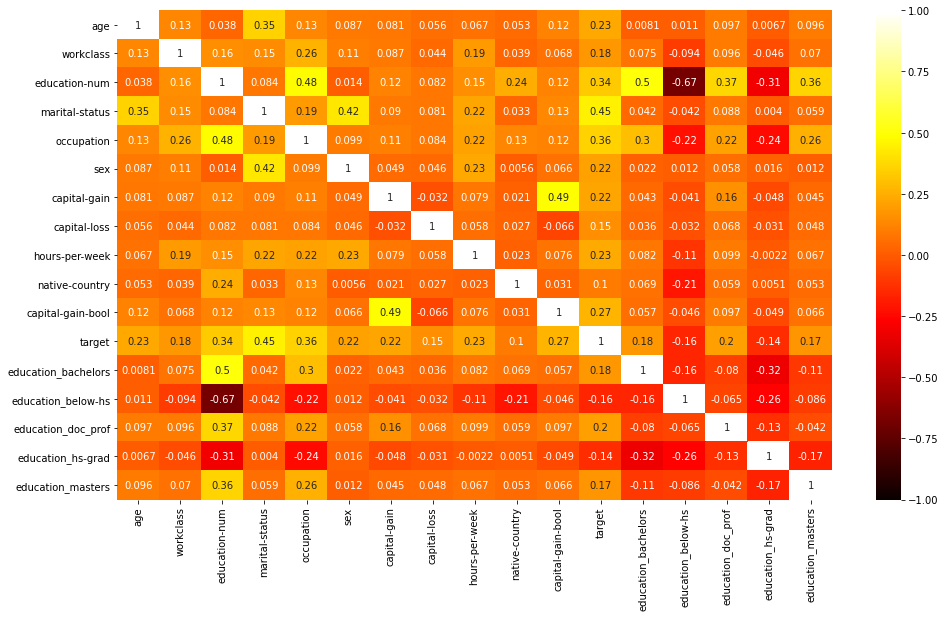

In [17]:
#Look at correlation between all features
plt.figure(figsize=(16,9))
sns.heatmap(X_train.corr(),vmin = -1, vmax = 1, cmap = 'hot', annot = True);

---
# Section 4 - Modeling
---
## Overview of Various Models

In [18]:
# Lets make a dictionary to automate my modelling - Source code from Michael Winder
log = LogisticRegression()
knnc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
bagc = BaggingClassifier()
rfc = RandomForestClassifier()
adac = AdaBoostClassifier()
svc = SVC()

models = {
    'log' : log,
    'knn' : knnc,
    'dt' : dtc,
    'bag' : bagc,
    'rf' : rfc,
    'ada' : adac,
    'svr' : svc
}

#Ensure X_train and y_train variables are appropiate
X_train = X_train.drop(columns=['target', 'capital-loss', 'capital-gain', 'education-num'])
X_test = X_test.drop(columns=['target', 'capital-loss', 'capital-gain', 'education-num'])

for est in models.values():
    print(est)
    est.fit(X_train, y_train)
    print(f'Training Score: {round(est.score(X_train, y_train), 4)}')
    print(f'Testing Score: {round(est.score(X_test, y_test), 4)}')
    print('')

LogisticRegression()


/Users/stephenstrawbridge/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Score: 0.8362
Testing Score: 0.8371

KNeighborsClassifier()
Training Score: 0.8611
Testing Score: 0.8104

DecisionTreeClassifier()
Training Score: 0.9666
Testing Score: 0.7982

BaggingClassifier()
Training Score: 0.9556
Testing Score: 0.8214

RandomForestClassifier()
Training Score: 0.9666
Testing Score: 0.8291

AdaBoostClassifier()
Training Score: 0.844
Testing Score: 0.8434

SVC()
Training Score: 0.776
Testing Score: 0.7861



In [19]:
#Scale data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

#Observe KNN after scaling data
knn = KNeighborsClassifier()
knn.fit(Z_train, y_train)
print(f'KNN Cross Validation Score: {cross_val_score(knn, Z_train, y_train, cv = 5).mean()}')
print(f'KNN Training Score: {round(knn.score(Z_train, y_train), 4)}')
print(f'KNN Testing Score: {round(knn.score(Z_test, y_test), 4)}')

KNN Cross Validation Score: 0.8217521645137292
KNN Training Score: 0.8747
KNN Testing Score: 0.8257


##### *After taking a look at the initial scores of various models above, further tuning of hyperparameters was done below for 1. Logistic Regression, 2. KNN, and 3. Random Forests. The best results for each of these 3 models is shown.*

---
## 1. Logistic Regression
---


In [20]:
#First, scale our data as this is best practice for logisic regression
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [21]:
log_params = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [50, 100, 200],
}

In [22]:
log_gridsearch = GridSearchCV(LogisticRegression(), # What is the model we want to fit?
                              log_params, # What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              )

In [23]:
#Fit model
log_gridsearch.fit(Z_train, y_train);

In [24]:
log_gridsearch.best_params_

{'max_iter': 50, 'solver': 'liblinear'}

In [25]:
log_gridsearch.best_score_

0.837146994589683

In [26]:
print(f'Logistics Training Score: {round(log_gridsearch.score(Z_train, y_train), 4)}')
print(f'Logistics Testing Score: {round(log_gridsearch.score(Z_test, y_test), 4)}')

Logistics Training Score: 0.8368
Logistics Testing Score: 0.8368


In [27]:
# logistic_coefs = pd.Series(log_gridsearch.coef_[0], index = X_train.columns)
# logistic_coefs = logistic_coefs.sort_values(ascending=False)
# logistic_coefs

---
## 2. KNN
---


In [28]:
def bestestimator(params):
    gs = GridSearchCV(estimator = KNeighborsClassifier(),
                         param_grid = params,
                         n_jobs = 3,
                         cv = 5,
                         verbose = 2)
    gs.fit(Z_train, y_train)
    be = gs.best_estimator_
    print(gs.best_params_)
    be.fit(Z_train, y_train)
    print(f'Train: {be.score(Z_train, y_train)}')
    print(f'Test: {be.score(Z_test, y_test)}')

In [29]:
knn_params = {'n_neighbors':[27,28,29],
              'weights':['distance','uniform']
             }

In [30]:
bestestimator(knn_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:   27.2s finished


{'n_neighbors': 28, 'weights': 'uniform'}
Train: 0.8506603194103194
Test: 0.839987714987715


---
## 3. Random Forests
---


In [31]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier(random_state = 1))
])

#params = {
#    'rf__n_estimators':[200, 350, 500, 750, 1000],
#    'rf__max_depth': [5, 10, 20, 30],
#    'rf__max_features': [10,20, 30, 50],
#    'rf__min_samples_split':[3,4,5],
#    'rf__min_samples_leaf': [3,5,7]
#}

#rerun with best params from above param grid 
params = {
    'rf__n_estimators':[500],
    'rf__max_depth': [10],
    'rf__max_features': [10],
    'rf__min_samples_split':[3],
    'rf__min_samples_leaf': [7]
}


gs_rf = GridSearchCV(pipe, params, cv=5, n_jobs=5)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.8426368138122082
{'rf__max_depth': 10, 'rf__max_features': 10, 'rf__min_samples_leaf': 7, 'rf__min_samples_split': 3, 'rf__n_estimators': 500}


See Notebook 2 for further analysis of our highest scoring model, Adaboost